In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import random
import math
import os
import warnings

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

In [3]:
def NormalEquation(matX,vecY):
    X_transpose = np.transpose(matX)

    left_side = np.dot(X_transpose,matX)
    right_side = np.dot(X_transpose,vecY)

    ans = np.linalg.inv(left_side).dot(right_side)
    return ans

def generate_feature_matrix(x, degree):
    if degree == 0:
        X = np.ones((len(x), 1))
        return X
    elif degree == 1:
        X = np.column_stack((np.ones(len(x)), x))
        return X
    elif degree > 1:
        X_poly = np.column_stack([x ** d for d in range(0, degree+1)])
        return X_poly
    else:
        raise ValueError("Degree must be a non-negative integer.")

def CalculateMSE(x_positions, y_positions, w_list):
    n = len(x_positions)
    x_positions = generate_feature_matrix(x_positions,len(w_list)-1)
    MSE = 0
    for i in range(0, n):
        wx = np.dot(x_positions[i],np.flip(w_list))
        MSE += (wx - y_positions[i]) ** 2
        
    MSE *= 1/(n)
    # print("new",MSE)
    return MSE

def testCalculateMSE(x_positions, y_positions, w_list):
    x = np.array(x_positions)
    n = len(x_positions)
    MSE = 0
    for i in range(0, n):
        wx, count = 0, 0
    for w in w_list:
        wx += w * x[i, count-1] if count > 0 else w
        count += 1
        MSE += (wx - y_positions[i]) ** 2
    MSE *= 1/(n)
    return MSE

In [4]:
warnings.simplefilter('ignore', np.RankWarning)

In [5]:
df = pd.read_csv("data/sin experiment/sin_noiseless_80sample.csv")
print(df["y"])

0    -1.220000e-16
1    -7.845910e-02
2    -1.564345e-01
3    -2.334454e-01
4    -3.090170e-01
          ...     
75    3.826834e-01
76    3.090170e-01
77    2.334454e-01
78    1.564345e-01
79    7.845910e-02
Name: y, Length: 80, dtype: float64


In [5]:
def cross_validation(X, y, folds, degree):
    k_folds = KFold(n_splits=folds)
    
    avg_rmse = []
    for train_index, validate_index in k_folds.split(X):
        # print(train_index,validate_index)
        X_train , X_validate = X.iloc[train_index], X.iloc[validate_index]
        y_train , y_validate = y.iloc[train_index], y.iloc[validate_index]

        result = np.polyfit(X_train.values.flatten(), np.array(y_train), degree)

        avg_rmse.append(CalculateMSE(X_validate.values.flatten(), np.array(y_validate), result)**(1/2))
    
    return np.average(avg_rmse)

def cross_validate_for_degree(x, y, folds, degree_list):
    best_degree = -1
    rmse_list = []
    for degree in degree_list:
        rmse_list.append(cross_validation(x, y, folds, degree))
    best_degree = degree_list[rmse_list.index(min(rmse_list))]
    return (rmse_list, best_degree)

def nested_cross_validation(X, y, folds, degree_list):
    k_folds = KFold(n_splits=folds)

    rmse_list = []

    for train_index, test_index in k_folds.split(X):
        X_train , X_test = X.iloc[train_index], X.iloc[test_index]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]

        degree = cross_validate_for_degree(X_train, y_train, min(len(X_train),folds), degree_list)[1]


        model = np.polyfit(X_train["x"].values.flatten(), np.array(y_train), degree)
        rmse_list.append(CalculateMSE(X_test["x"].values.flatten(), np.array(y_test), model)**(1/2))

    return np.average(rmse_list)

In [6]:
print(cross_validation(df["x"], df["noisy_y"], 10, 8))

9.802671746031654


In [7]:
cross_validate_for_degree(df["x"], df["noisy_y"], 10, range(1,9))

([0.5860538374296972,
  0.6147454685356424,
  0.33546034532258595,
  0.4838865801905616,
  1.1152157716473543,
  0.841197014903728,
  2.434697380040701,
  9.802671746031654],
 3)

In [17]:
for filename in os.listdir(os.path.abspath("data/sin experiment")):
    path = os.path.join("data/sin experiment", filename)
    print(path)

    df = pd.read_csv(path)

    y = df["y"] if "noiseless" in filename else df["noisy_y"]
    #print(round(nested_cross_validation(df[list(df)[:-2]], y, 10, range(1,9)), 4))
    print(round(min(cross_validate_for_degree(df["x"], y, 10, range(1,11))[0]),4))

data/sin experiment\sin_noiseless_10sample.csv
0.0029
data/sin experiment\sin_noiseless_20sample.csv
0.0001
data/sin experiment\sin_noiseless_40sample.csv
0.0
data/sin experiment\sin_noiseless_80sample.csv
0.0
data/sin experiment\sin_noisy_10sample.csv
0.3355
data/sin experiment\sin_noisy_20sample.csv
0.3154
data/sin experiment\sin_noisy_40sample.csv
0.2827
data/sin experiment\sin_noisy_80sample.csv
0.2987


In [45]:
y_name = list(df)[-1]

ref_x = np.linspace(-1,1,10000)
ref_y = np.sin(np.pi*ref_x)
ref_data = np.column_stack((ref_x,ref_y))
ref_df = pd.DataFrame(ref_data, columns=["x","y"])
print(ref_df)

train_results = {}
for degree in range(0,9):
    model = np.polyfit(ref_df["x"].values.flatten(), np.array(ref_df["y"]), degree)
    train_results[degree] = CalculateMSE(ref_df["x"].values.flatten(), np.array(ref_df["y"]), model)**(1/2)

print(train_results)

cv_results = []
nested_results = []
delta_result = []
ref_errors = []
for i in range(10):
    new_df = df.sample(frac = 1, random_state=i, ignore_index=True)
    cv_errors, best_degree = cross_validate_for_degree(new_df["x"], new_df[y_name], 10, range(0,9))
    cv_result = min(cv_errors)
    nested_result = nested_cross_validation(new_df[["x"]], new_df[y_name], 10, range(0,9))

    print(cv_result)
    print(nested_result)
    print(train_results[degree], degree)
    print(nested_result - cv_result, "\n")
    cv_results.append(cv_result)
    nested_results.append(nested_result)
    ref_errors.append(train_results[degree])
    delta_result.append(nested_result - cv_result)

{0: 0.7071067811527912, 1: 0.443059192383651, 2: 0.4422546883021898, 3: 0.06642038088138469, 4: 0.0659829686985429, 5: 0.004314319090972547, 6: 0.004254573057918102, 7: 0.00015686159414937662, 8: 0.00015318514999688402}
0.00019509854029549253
0.00020398215031497028
0.00015318514999688402 8
8.883610019477751e-06 

0.00019215949221493078
0.00019215949221493078
0.00015318514999688402 8
0.0 

0.00018557757959411706
0.00019786943464592064
0.00015318514999688402 8
1.229185505180358e-05 

0.00018940563637634614
0.00018940563637634614
0.00015318514999688402 8
0.0 

0.00019038556301882124
0.00019038556301882124
0.00015318514999688402 8
0.0 

0.00022113558458771625
0.00022113558458771625
0.00015318514999688402 8
0.0 

0.00019506280850704183
0.00020453735157295372
0.00015318514999688402 8
9.474543065911886e-06 

0.00019252958902721886
0.00019252958902721886
0.00015318514999688402 8
0.0 

0.00018500564262361819
0.00018783868744713637
0.00015318514999688402 8
2.8330448235181795e-06 

0.000188130327

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


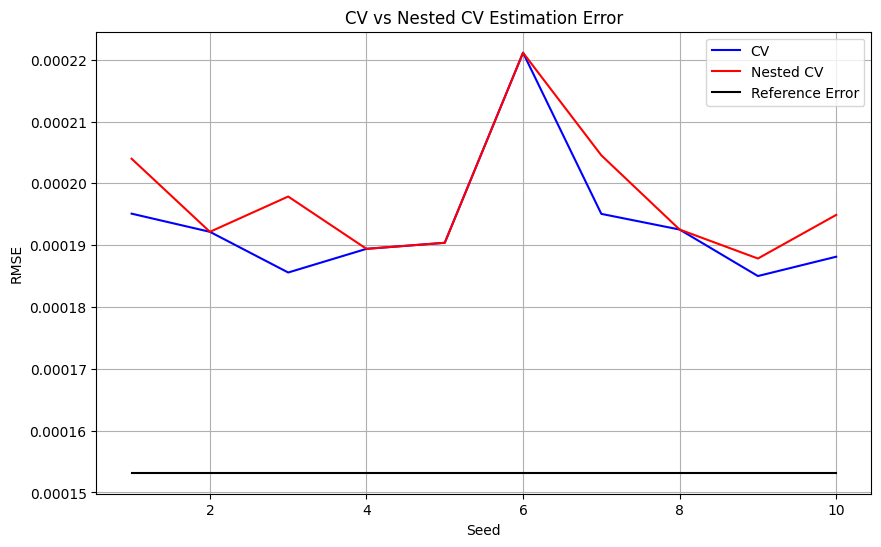

In [46]:
import matplotlib.pyplot as plt

# Generate x values for plotting
x_values = np.linspace(1, 10, 10)  # Adjust the range as needed
print(x_values)

# Evaluate the polynomial for each x value

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, cv_results, label='CV', color='blue')
plt.plot(x_values, nested_results, label='Nested CV', color='red')
plt.plot(x_values, ref_errors, label='Reference Error', color = 'black')
plt.xlabel('Seed')
plt.ylabel('RMSE')
plt.title('CV vs Nested CV Estimation Error')
plt.legend()
plt.grid()
plt.show()

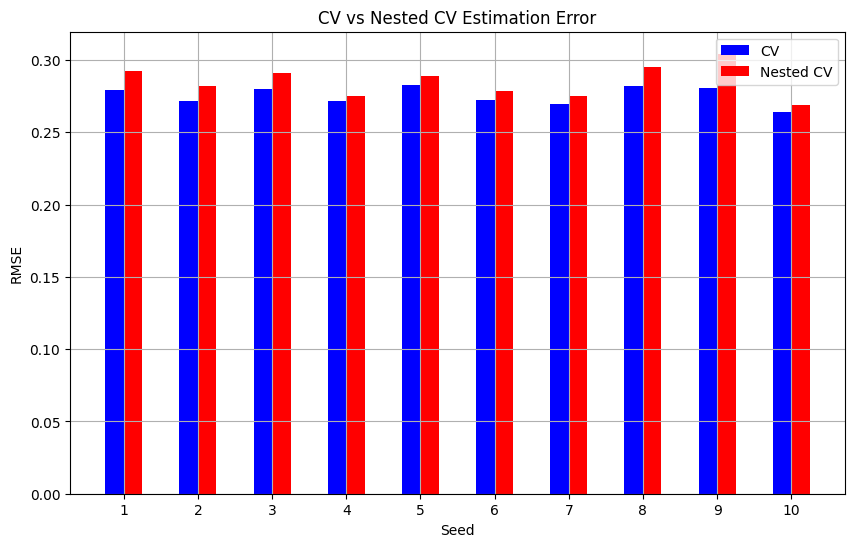

In [20]:
x_values = np.linspace(1, 10, 10)
plt.figure(figsize=(10, 6))

bar_width = 0.25

plt.bar(x_values - bar_width/2, cv_results, label='CV', color='blue', width=bar_width)
plt.bar(x_values + bar_width/2, nested_results, label='Nested CV', color='red', width=bar_width)
plt.xlabel('Seed')
plt.ylabel('RMSE')
plt.xticks(range(1,11))
plt.title('CV vs Nested CV Estimation Error')
plt.legend()
plt.grid()
plt.show()

In [6]:
SEEDS = 30

cv_results = []
nested_results = []
delta_result = []
chosen_degrees = []
ref_errors = []
for i in range(3,101):
    temp_cv_result = 0
    temp_nested_result = 0
    temp_delta_result = 0
    temp_chosen_degree = 0
    temp_train_result = 0
    temp_best_degree = 0
    for seed in range(SEEDS):
        new_x = np.random.uniform(-1,1,i)
        np.random.seed(seed)
        new_y = np.sin(np.pi*new_x) + np.random.normal(0, 0.2, i)
        new_data = np.column_stack((new_x,new_y))
        new_df = pd.DataFrame(new_data, columns=["x","y"])

        train_results = {}
        for degree in range(0,20):
            model = np.polyfit(new_df["x"].values.flatten(), np.array(new_df["y"]), degree)
            train_results[degree] = CalculateMSE(new_df["x"].values.flatten(), np.array(new_df["y"]), model)**(1/2)

        cv_errors, best_degree = cross_validate_for_degree(new_df["x"], new_df["y"], min(i,10), range(0,20))
        cv_result = min(cv_errors)
        nested_result = nested_cross_validation(new_df[["x"]], new_df["y"], min(i,10), range(0,20))

        temp_cv_result += cv_result
        temp_nested_result += nested_result
        temp_train_result += train_results[best_degree]
        temp_best_degree += best_degree

    cv_results.append(temp_cv_result/SEEDS)
    nested_results.append(temp_nested_result/SEEDS)
    ref_errors.append(temp_train_result/SEEDS)
    delta_result.append((temp_nested_result - cv_result)/SEEDS)
    chosen_degrees.append(round(temp_best_degree/SEEDS))

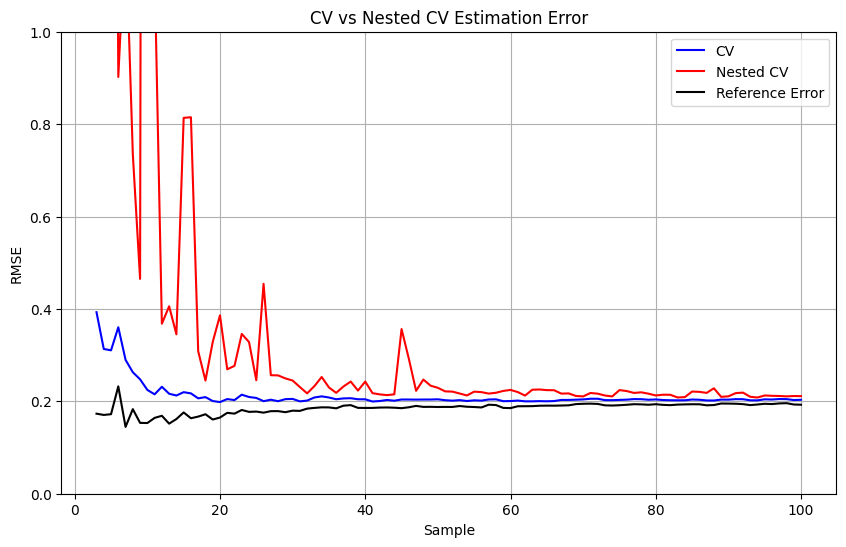

In [8]:
import matplotlib.pyplot as plt

# Generate x values for plotting
x_values = np.linspace(3, 100, 101-3)  # Adjust the range as needed

# Evaluate the polynomial for each x value

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, cv_results, label='CV', color='blue')
plt.plot(x_values, nested_results, label='Nested CV', color='red')
plt.plot(x_values, ref_errors, label='Reference Error', color = 'black')
plt.xlabel('Sample')
plt.ylabel('RMSE')
plt.ylim(0,1)
plt.title('CV vs Nested CV Estimation Error')
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


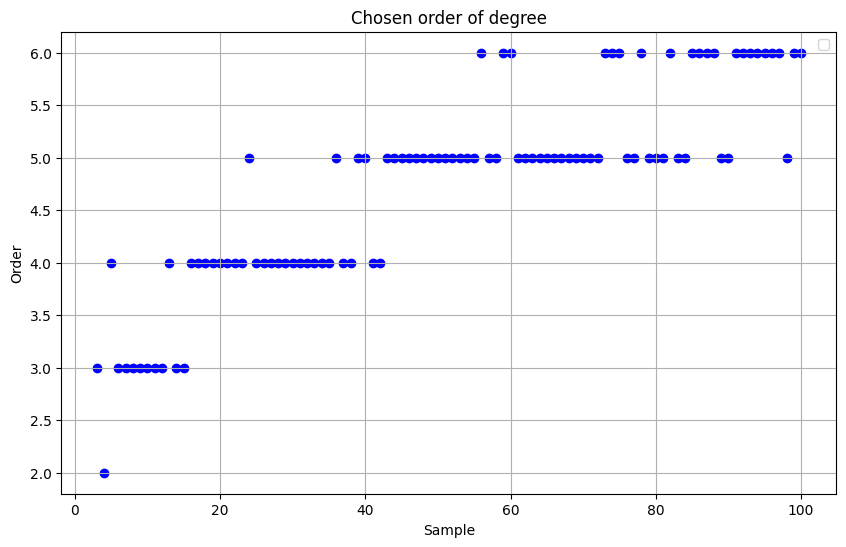

In [9]:
# Generate x values for plotting
x_values = np.linspace(3, 100, 101-3)  # Adjust the range as needed

# Evaluate the polynomial for each x value

# Plot the graph
plt.figure(figsize=(10, 6))
plt.scatter(x_values, chosen_degrees, color='blue')
#plt.plot(x_values, nested_results, label='Nested CV', color='red')
#plt.plot(x_values, ref_errors, label='Reference Error', color = 'black')
plt.xlabel('Sample')
plt.ylabel('Order')
plt.title('Chosen order of degree')
plt.legend()
plt.grid()
plt.show()

In [37]:
np.random.seed(1)
print(np.random.normal(0, 0.2, 10))
print(np.random.normal(0, 0.2, 11))

[ 0.32486907 -0.12235128 -0.10563435 -0.21459372  0.17308153 -0.46030774
  0.34896235 -0.15224138  0.06380782 -0.04987408]
[ 0.29242159 -0.41202814 -0.06448344 -0.07681087  0.22675389 -0.21997825
 -0.03448564 -0.17557168  0.00844275  0.11656304 -0.22012384]
